In [1]:
import snap
import sys, os
from collections import defaultdict
import itertools
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Data Constants

In [2]:
comment_dir = 'data/comments/'

subreddit_name_file = 'data/subredditIdToName'

filtered_users_file = 'data/filteredUsers'
filtered_subreddit_ids_file = 'data/filteredSubreddits'

user_node_ids_file = 'data/user_node_ids.npy'
subreddit_node_ids_file = 'data/subreddit_node_ids.npy'

train_comment_graph_file = 'data/train_comment_graph.txt'
test_comment_graph_file = 'data/test_comment_graph.txt'

train_subreddit_graph_file = 'data/train_subreddit_graph.txt'
test_subreddit_graph_file = 'data/test_subreddit_graph.txt'

## Load Data Structures

In [3]:
##############################################
# Load Raw Reddit Data
##############################################
def read_subreddit_names(filename):
    """
    Reads in file with global mappings from subreddit ids to names.
    Filters out subreddit names that begin with 'u_'.

    Examples: [subreddit_id subreddit_name]
        ...
        t5_3m6wn hormuz
        t5_bx9mz u_Ubiver
        ...

    Returns a dictionary mapping from id to name and a set of
    unique subreddit ids.
    """
    subreddit_name_dict = {} # id -> subreddit
    with open(filename) as f:
        for line in f:
            subreddit_id, subreddit_name = line.split()
            if subreddit_name.startswith('u_'): # not subreddit!
                continue
            subreddit_name_dict[subreddit_id] = subreddit_name
    return subreddit_name_dict

def read_filtered_users(filename):
    """
    """
    filtered_users = set() 
    with open(filename) as f:
        for line in f:
            user = line.strip()
            filtered_users.add(user)
    return filtered_users

def read_filtered_subreddit_ids(filename):
    """
    """
    filtered_subredit_ids = set() 
    with open(filename) as f:
        for line in f:
            subreddit_id = line.strip()
            filtered_subredit_ids.add(subreddit_id)
    return filtered_subredit_ids

def read_subreddit_comments(dirname, subreddit_name_dict, filtered_users=None, filtered_subreddit_ids=None, target_months=None):
    """
    Reads in files containing user-subreddit commenting counts. Each file
    name is of the format RC_YYYY-MM where YYYY and MM are year and month,
    respectively.

    Examples: [user subreddit_id comment_count]
        ...
        PGHContrarian68 t5_2ve45 4
        TheIncompetenceOfMan t5_2qh33 11
        ...

    Each edge is represented as (user, subreddit_id) and is weighted by
    the cumulative number of comments by the user on the subreddit.
    Note we only consider edges with existing subreddit_ids.

    Returns dictionary containing edges weighted by comments and
    and a set of unique users.
    """
    # Nodes
    users = set() # unique users 
    subreddits_ids = set() # unique subreddit ids
    
    # Edge set and weights
    comment_edges = set() # unique comment (user, subreddit_id) edges
    comment_weights = defaultdict(int) # edge (user, subreddit_id) -> comment_count
    
    # Edge dictionaries
    user_subreddit_dict = defaultdict(set) # user -> set(subreddit_ids)
    subreddit_user_dict = defaultdict(set) # subreddit_id -> set(users)
    
    for foldername, subdirlist, filelist in os.walk(dirname, topdown=False):
        for fname in sorted(filelist):
            if fname.startswith('RC_'): # formated as RC_YYYY-MM
                # Parse filename for date information
                _, yyyymm = fname.split('_')
                yyyy, mm = yyyymm.split('-')
                                
                # Only parse target months
                if target_months is not None and mm not in target_months:
                    continue
                    
                month_users = set()
                month_subreddit_ids = set()
                month_comment_edges = set()

                # Parse the file for edge weights
                with open(os.path.join(dirname, fname)) as f:
                    for line in f:
                        user, subreddit_id, comment_count = line.split() # e.g. kittykapow925, t5_2yrq6, 1
                        
                        # Skip filtered users and subreddit_ids
                        if filtered_users is not None and user in filtered_users: 
                            continue
                        if filtered_subreddit_ids is not None and subreddit_id in filtered_subreddit_ids:
                            continue
                        
                        # Skip non-existent subreddit_ids
                        if subreddit_id not in subreddit_name_dict: 
                            continue
                            
                        month_users.add(user)
                        month_subreddit_ids.add(subreddit_id)
                        month_comment_edges.add((user, subreddit_id))
                        
                        comment_weights[(user, subreddit_id)] += int(comment_count)
                        user_subreddit_dict[user].add(subreddit_id)
                        subreddit_user_dict[subreddit_id].add(user)
                
                print "Done processing file: ", fname
                
                # Print statistics about new nodes and edges
                new_users = month_users.difference(users)
                new_subreddits_ids = month_subreddit_ids.difference(subreddits_ids)
                new_comment_edges = month_comment_edges.difference(comment_edges)
                
                print "- Number of new users %s / %s" % (len(new_users), len(month_users)) 
                print "- Number of new subreddits %s / %s" % (len(new_subreddits_ids), len(month_subreddit_ids)) 
                print "- Number of new comment interactions %s / %s" % (len(new_comment_edges), len(month_comment_edges)) 
                
                # Merge sets together
                users = users.union(month_users)
                subreddits_ids = subreddits_ids.union(month_subreddit_ids)
                comment_edges = comment_edges.union(month_comment_edges)
    return comment_weights, comment_edges, users, subreddits_ids, user_subreddit_dict, subreddit_user_dict

In [4]:
subreddit_name_dict = read_subreddit_names(subreddit_name_file) # subreddit_id -> subreddit

print "Done processing subreddit name dictionary."

Done processing subreddit name dictionary.


In [5]:
filtered_users = read_filtered_users(filtered_users_file)
filtered_subreddit_ids = read_filtered_subreddit_ids(filtered_subreddit_ids_file)

print "Number of users to filter: ", len(filtered_users) 
print "Number of subreddits to filter: ", len(filtered_subreddit_ids) 

Number of users to filter:  5586566
Number of subreddits to filter:  98959


In [6]:
# Load node_id mappings from disk for all 6 months
user_node_ids = np.load(user_node_ids_file).item() # user -> user_node_id
subreddit_node_ids = np.load(subreddit_node_ids_file).item() # subreddit_id -> subreddit_node_id

print "Number of users_node_ids: ", len(user_node_ids)
print "Number of subreddit_node_ids: ", len(subreddit_node_ids)

Number of users_node_ids:  9731646
Number of subreddit_node_ids:  162242


### Load Filtered Train Set (5-Months)

In [7]:
TRAIN_MONTHS = ['01', '02', '03', '04', '05'] 

train_comment_weights, train_comment_edges, train_users, train_subreddit_ids, train_user_subreddit_dict, train_subreddit_user_dict = read_subreddit_comments(comment_dir, subreddit_name_dict, filtered_users=filtered_users, filtered_subreddit_ids=filtered_subreddit_ids, target_months=TRAIN_MONTHS)

print "TRAIN: Number of unique users: ", len(train_users)
print "TRAIN: Number of unique subreddits: ", len(train_subreddit_ids)
print "TRAIN: Number of unique comment edges: ", len(train_comment_edges)

Done processing file:  RC_2018-01
- Number of new users 2535254 / 2535254
- Number of new subreddits 44961 / 44961
- Number of new comment interactions 14999948 / 14999948
Done processing file:  RC_2018-02
- Number of new users 365537 / 2595779
- Number of new subreddits 3191 / 45936
- Number of new comment interactions 9682492 / 15054037
Done processing file:  RC_2018-03
- Number of new users 206078 / 2684168
- Number of new subreddits 1830 / 46835
- Number of new comment interactions 9078163 / 16244038
Done processing file:  RC_2018-04
- Number of new users 125226 / 2729598
- Number of new subreddits 1293 / 47264
- Number of new comment interactions 8371083 / 16625917
Done processing file:  RC_2018-05
- Number of new users 57688 / 2707236
- Number of new subreddits 776 / 47259
- Number of new comment interactions 8082335 / 17265784
TRAIN: Number of unique users:  3289783
TRAIN: Number of unique subreddits:  52051
TRAIN: Number of unique comment edges:  50214021


In [8]:
TEST_MONTHS = ['06']

test_comment_weights, test_comment_edges, test_users, test_subreddit_ids, test_user_subreddit_dict, test_subreddit_user_dict = read_subreddit_comments(comment_dir, subreddit_name_dict, filtered_users=filtered_users, filtered_subreddit_ids=filtered_subreddit_ids, target_months=TEST_MONTHS)

print "TEST: Number of unique users: ", len(test_users)
print "TEST: Number of unique subreddits: ", len(test_subreddit_ids)
print "TEST: Number of unique comment edges: ", len(test_comment_edges)

Done processing file:  RC_2018-06
- Number of new users 3311010 / 3311010
- Number of new subreddits 55928 / 55928
- Number of new comment interactions 17327567 / 17327567
TEST: Number of unique users:  3311010
TEST: Number of unique subreddits:  55928
TEST: Number of unique comment edges:  17327567


### Training Set Analysis (5-Months)

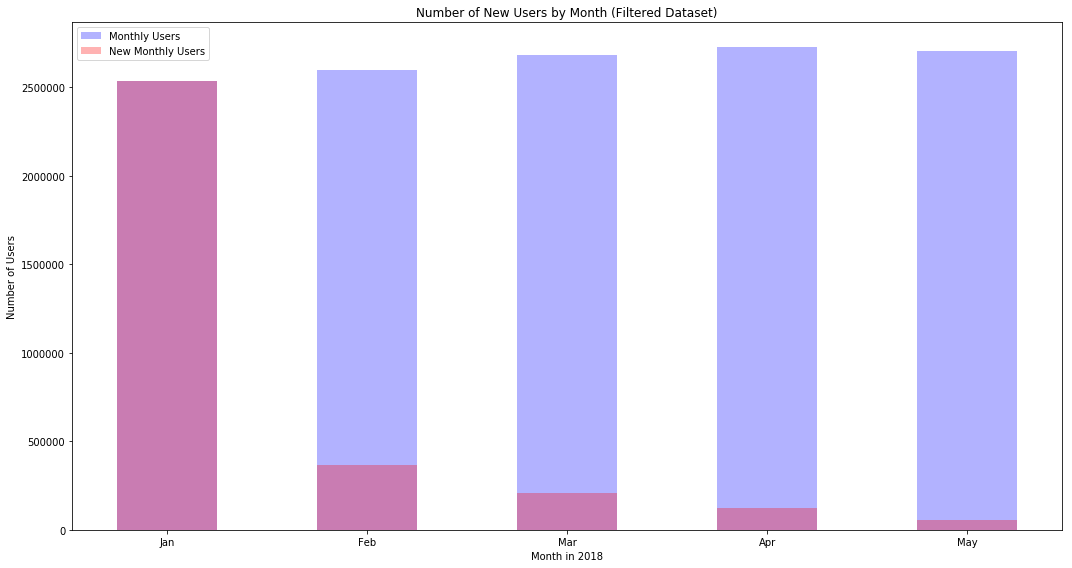

In [43]:
n_months = 5

new_items = (2535254, 365537, 206078, 125226, 57688)
total_items = (2535254, 2595779, 2684168, 2729598, 2707236)

fig, ax = plt.subplots()

index = np.arange(n_months)
bar_width = 0.5

opacity = 0.3

rects1 = ax.bar(index, total_items, bar_width,
                alpha=opacity, color='b',
                label='Monthly Users')

rects2 = ax.bar(index, new_items, bar_width,
                alpha=opacity, color='r',
                label='New Monthly Users')

ax.set_xlabel('Month in 2018')
ax.set_ylabel('Number of Users')
ax.set_title('Number of New Users by Month (Filtered Dataset)')
ax.set_xticks(index)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May'))
ax.legend()

fig.tight_layout()
plt.show()

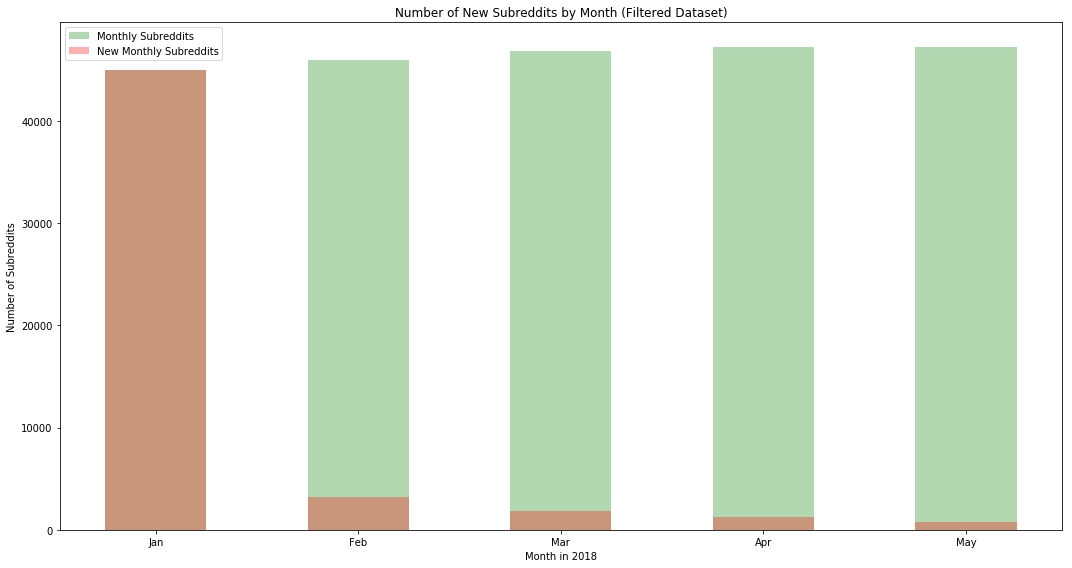

In [42]:
n_months = 5

new_items = (44961, 3191, 1830, 1293, 776)
total_items = (44961, 45936, 46835, 47264, 47259)

fig, ax = plt.subplots()

index = np.arange(n_months)
bar_width = 0.5

opacity = 0.3

rects1 = ax.bar(index, total_items, bar_width,
                alpha=opacity, color='g',
                label='Monthly Subreddits')

rects2 = ax.bar(index, new_items, bar_width,
                alpha=opacity, color='r',
                label='New Monthly Subreddits')

ax.set_xlabel('Month in 2018')
ax.set_ylabel('Number of Subreddits')
ax.set_title('Number of New Subreddits by Month (Filtered Dataset)')
ax.set_xticks(index)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May'))
ax.legend()

fig.tight_layout()
plt.show()

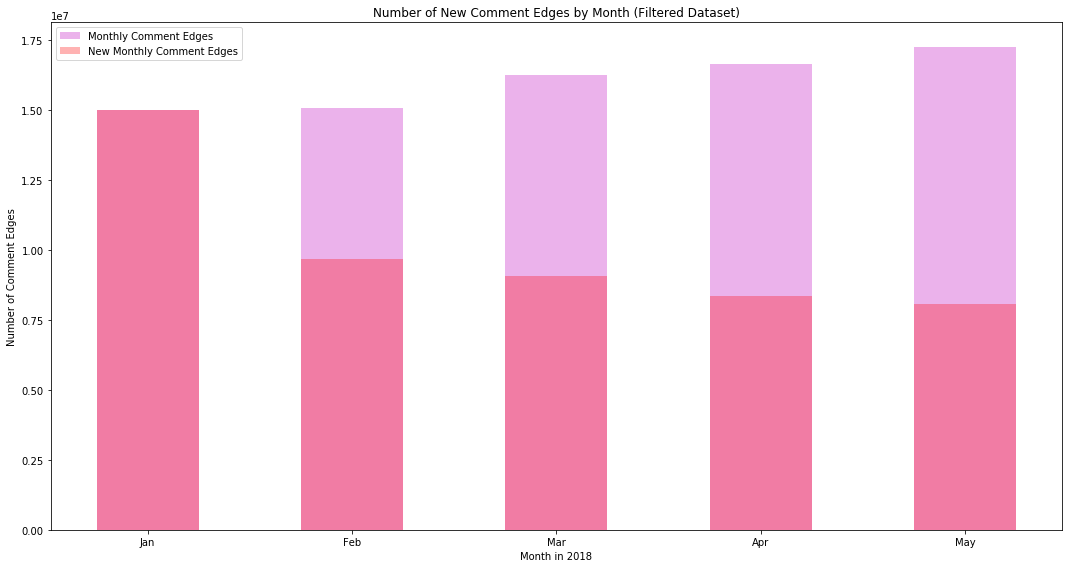

In [44]:
n_months = 5

new_items = (14999948, 9682492, 9078163, 8371083, 8082335)
total_items = (14999948, 15054037, 16244038, 16625917, 17265784)

fig, ax = plt.subplots()

index = np.arange(n_months)
bar_width = 0.5

opacity = 0.3

rects1 = ax.bar(index, total_items, bar_width,
                alpha=opacity, color='m',
                label='Monthly Comment Edges')

rects2 = ax.bar(index, new_items, bar_width,
                alpha=opacity, color='r',
                label='New Monthly Comment Edges')

ax.set_xlabel('Month in 2018')
ax.set_ylabel('Number of Comment Edges')
ax.set_title('Number of New Comment Edges by Month (Filtered Dataset)')
ax.set_xticks(index)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May'))
ax.legend()

fig.tight_layout()
plt.show()

In [10]:
def print_subreddit_statistics(comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict, subreddit_user_dict):
    print "Number of average subreddits per user: ", 1.0 * len(comment_edges) /  len(users)
    total_num_comments = sum(comment_weights.itervalues())
    print "Number of average comments per user: ", 1.0 * total_num_comments /  len(users)

#     subreddit_freq_dict = defaultdict(int)
#     for user, subreddits in user_subreddit_dict.iteritems():
#         subreddit_freq_dict[len(subreddits)] += 1

#     max_subreddit_count = 30
#     subreddit_counts = np.arange(1, max_subreddit_count)
#     num_users = [subreddit_freq_dict[subreddit_count] for subreddit_count in subreddit_counts]
    
#     plt.title("How Many Users Commented on N-Subreddits? (Jan-May)")
#     plt.xlabel("N-Subreddits")
#     plt.ylabel("Number of Users")
#     plt.bar(subreddit_counts, num_users)
#     plt.show()
    
#     # The slices will be ordered and plotted counter-clockwise.
#     labels = [(str(subreddit_count) + " Subreddit(s)") for subreddit_count in subreddit_counts[:15]] + ['16+ Subreddits']# ['Rayos X (88.4 %)', 'RMN en solucion (10.6 %)', 'Microscopia electronica (0.7 %)', 'Otros (0.3 %)']
#     sizes = num_users[:15] + [sum(num_users[15:])] # [88.4, 10.6, 0.7, 0.3]
#     patches, texts = plt.pie(sizes, startangle=90)
#     plt.title("Proportion of Users that Commented on N-Subreddits (Jan-May)")
#     plt.legend(patches, labels, loc="best")
#     # Set aspect ratio to be equal so that pie is drawn as a circle.
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.show()
    
#     print "Top-15 user counts: ", num_users[:max_subreddit_count]
#     print "Percent of users who comment on just 1 Subreddit: ", 100.0 * subreddit_freq_dict[1] / len(users)
#     print "Percent of users who comment on just 1 or 2 Subreddits: ", 100.0 * (subreddit_freq_dict[1] + subreddit_freq_dict[2])/ len(users)
#     print "Percent of users who comment on just 1, 2, or 3 Subreddits: ", 100.0 * (subreddit_freq_dict[1] + subreddit_freq_dict[2] + subreddit_freq_dict[3])/ len(users)
    
#     user_freq_dict = defaultdict(int)
#     for subreddit, users in subreddit_user_dict.iteritems():
#         user_freq_dict[len(users)] += 1
    
#     max_user_count = 30
#     user_counts = np.arange(1, max_user_count)
#     num_subreddits = [user_freq_dict[user_count] for user_count in user_counts]

#     plt.title("How Many Subreddits Had N-Users? (Jan-May)")
#     plt.xlabel("N-Users")
#     plt.ylabel("Number of Subreddits")
#     plt.bar(user_counts, num_subreddits)
#     plt.show()
    
#     # The slices will be ordered and plotted counter-clockwise.
#     labels = [(str(user_count) + " User(s)") for user_count in user_counts[:10]] + ['11+ Users']# ['Rayos X (88.4 %)', 'RMN en solucion (10.6 %)', 'Microscopia electronica (0.7 %)', 'Otros (0.3 %)']
#     sizes = num_subreddits[:10] + [sum(user_counts[10:])] # [88.4, 10.6, 0.7, 0.3]
# #     colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
#     patches, texts = plt.pie(sizes, startangle=90)
#     plt.title("Proportion of Subreddits That Had N-Users (Jan-May)")
#     plt.legend(patches, labels, loc="best")
#     # Set aspect ratio to be equal so that pie is drawn as a circle.
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.show()

In [11]:
print_subreddit_statistics(train_comment_weights, train_comment_edges, train_users, train_subreddit_ids, train_user_subreddit_dict, train_subreddit_user_dict)

Number of average subreddits per user:  15.2636271146
Number of average comments per user:  118.859144205


### Test Statistics: Unseen Nodes and Edges

In [13]:
new_test_users = test_users.difference(train_users)
print "CURRENT: Percent of users unseen: %.1f%% = %s / %s" % (100.0 * len(new_test_users) / len(test_users), len(new_test_users), len(test_users))

new_test_subreddit_ids = test_subreddit_ids.difference(train_subreddit_ids) 
print "CURRENT: Percent of subreddits unseen: %.1f%% = %s / %s" % (100.0 * len(new_test_subreddit_ids) / len(test_subreddit_ids), len(new_test_subreddit_ids), len(test_subreddit_ids))

new_test_comment_edges = test_comment_edges.difference(train_comment_edges)
print "CURRENT: Percent of comment edges unseen: %.1f%% = %s / %s" % (100.0 * len(new_test_comment_edges) / len(test_comment_edges), len(new_test_comment_edges), len(test_comment_edges))

CURRENT: Percent of users unseen: 25.4% = 840809 / 3311010
CURRENT: Percent of subreddits unseen: 18.4% = 10285 / 55928
CURRENT: Percent of comment edges unseen: 45.3% = 7847365 / 17327567


In [36]:
# ##############################################
# # Construct Node and Edge IDs
# ##############################################
# def generate_node_ids(alls_users, all_subreddit_ids):
#     """
#     Generate node ids by assigning each user a consecutive
#     integer value in [0, num_users) and each subreddit
#     a consecutive integer value in [num_users, num_users+num_subreddits)

#     Returns dictionaries of users and subreddit_ids to their corresponding
#     node ids.
#     """
#     num_users = len(alls_users) # = MAX_UID
#     num_subreddits = len(all_subreddit_ids)

#     # Iterate through sorted users
#     user_node_ids = {} # user -> user_node_id
#     users = sorted(alls_users)
#     for user_node_id, user in enumerate(users):
#         user_node_ids[user] = user_node_id

#     # Iterate through sorted subreddit ids
#     subreddit_node_ids = {} # subreddit_id -> subreddit_node_id
#     subreddit_ids = sorted(all_subreddit_ids)
#     for subreddit_node_id, subreddit_id in enumerate(subreddit_ids):
#         subreddit_node_ids[subreddit_id] = num_users + subreddit_node_id # shifted by num_users

#     return user_node_ids, subreddit_node_ids

In [37]:
# user_node_ids, subreddit_node_ids = generate_node_ids(users, subreddit_ids)

In [41]:
# # Save
# np.save(user_node_ids_file, user_node_ids) 
# np.save(subreddit_node_ids_file, subreddit_node_ids) 

## Load / Construct Bipartite User-Subreddit Graph (with Snap)

In [ ]:
# C_train = snap.LoadEdgeList(snap.PUNGraph, train_comment_graph_file, 0, 1, '\t')

# print "C_train: Number of nodes: ", C_train.GetNodes()
# print "C_train: Number of edges: ", C_train.GetEdges()

In [ ]:
# C_test = snap.LoadEdgeList(snap.PUNGraph, test_comment_graph_file, 0, 1, '\t')

# print "C_test: Number of nodes: ", C_test.GetNodes()
# print "C_test: Number of edges: ", C_test.GetEdges()

In [10]:
def construct_comment_graph(users, subreddit_ids, comment_edges, 
                            all_user_node_ids, all_subreddit_node_ids):
    """
    Creates a the User-Subreddit bipartite undirected graph where the nodes
    are users and subreddits and the edges between the users and subreddits
    represe nt when a user has commented on a subreddit.
    """
    # Construct the bipartise graph
    C = snap.PUNGraph.New()

    # Add user node ids
    for user in users:
        user_node_id = all_user_node_ids[user]
        C.AddNode(user_node_id)
        
    print "Done adding user nodes."

    # Add subreddit node ids
    for subreddit_id in subreddit_ids:
        subreddit_node_id = all_subreddit_node_ids[subreddit_id]
        C.AddNode(subreddit_node_id)
    
    print "Done adding subreddit nodes."
        
    # Add comment edges
    for i, comment_edge in enumerate(comment_edges):
        user, subreddit_id = comment_edge
        user_node_id = all_user_node_ids[user]
        subreddit_node_id = all_subreddit_node_ids[subreddit_id]
        C.AddEdge(user_node_id, subreddit_node_id)
        
        if i % 1000000 == 0:
            print "Processed %s / %s edges" % (i , len(comment_edges))

    print "Done adding comment edges."

    return C

In [50]:
C_train = construct_comment_graph(train_users, train_subreddit_ids, train_comment_edges, user_node_ids, subreddit_node_ids)

print "C_train: Number of nodes: ", C_train.GetNodes()
print "C_train: Number of edges: ", C_train.GetEdges()

Done adding user nodes.
Done adding subreddit nodes.
Processed 0 / 50214021 edges
Processed 1000000 / 50214021 edges
Processed 2000000 / 50214021 edges
Processed 3000000 / 50214021 edges
Processed 4000000 / 50214021 edges
Processed 5000000 / 50214021 edges
Processed 6000000 / 50214021 edges
Processed 7000000 / 50214021 edges
Processed 8000000 / 50214021 edges
Processed 9000000 / 50214021 edges
Processed 10000000 / 50214021 edges
Processed 11000000 / 50214021 edges
Processed 12000000 / 50214021 edges
Processed 13000000 / 50214021 edges
Processed 14000000 / 50214021 edges
Processed 15000000 / 50214021 edges
Processed 16000000 / 50214021 edges
Processed 17000000 / 50214021 edges
Processed 18000000 / 50214021 edges
Processed 19000000 / 50214021 edges
Processed 20000000 / 50214021 edges
Processed 21000000 / 50214021 edges
Processed 22000000 / 50214021 edges
Processed 23000000 / 50214021 edges
Processed 24000000 / 50214021 edges
Processed 25000000 / 50214021 edges
Processed 26000000 / 502140

In [51]:
snap.SaveEdgeList(C_train, train_comment_graph_file) # save graph to text file

In [47]:
C_test = construct_comment_graph(test_users, test_subreddit_ids, test_comment_edges, user_node_ids, subreddit_node_ids)

Done adding user nodes.
Done adding subreddit nodes.
Processed 0 / 17327567 edges
Processed 1000000 / 17327567 edges
Processed 2000000 / 17327567 edges
Processed 3000000 / 17327567 edges
Processed 4000000 / 17327567 edges
Processed 5000000 / 17327567 edges
Processed 6000000 / 17327567 edges
Processed 7000000 / 17327567 edges
Processed 8000000 / 17327567 edges
Processed 9000000 / 17327567 edges
Processed 10000000 / 17327567 edges
Processed 11000000 / 17327567 edges
Processed 12000000 / 17327567 edges
Processed 13000000 / 17327567 edges
Processed 14000000 / 17327567 edges
Processed 15000000 / 17327567 edges
Processed 16000000 / 17327567 edges
Processed 17000000 / 17327567 edges
Done adding comment edges.


In [48]:
print "C_test: Number of nodes: ", C_test.GetNodes()
print "C_test: Number of edges: ", C_test.GetEdges()

C_test: Number of nodes:  3366938
C_test: Number of edges:  17327567


In [49]:
snap.SaveEdgeList(C_test, test_comment_graph_file) # save graph to text file

## Print Basic Statistics about Graph

In [53]:
C_train_cluster_coeff = snap.GetClustCf(C_train, 1000)
C_train_density = float(C.GetEdges()) / (C_train.GetNodes() * (C_train.GetNodes() - 1))

print "Clustering Coefficient: ", C_train_cluster_coeff
print "Density: ", C_train_density

Clustering Coefficient:  0.0
Density:  4.49630106659e-06


## Plot Degree Distribution Graph

In [26]:
def getFilteredDataPointsToPlot(Graph, filtered_nodes, nodes_dict):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :filtered_nodes - list: list of Node IDs that we want to plot

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    N = len(filtered_nodes) # total number of nodes in graph

    # Get frequency counts of degree
    degreeFreq = {}
    for filtered_node in filtered_nodes:
        node_id = nodes_dict[filtered_node]
        node = Graph.GetNI(node_id)
        degree = node.GetOutDeg()
        if degree in degreeFreq:
            degreeFreq[degree] += 1
        else:
            degreeFreq[degree] = 1

    X, Y = [], []
    for degree, count in degreeFreq.iteritems():
        count_ratio = float(count) / N
        X.append(degree)
        Y.append(count_ratio)
    return X, Y

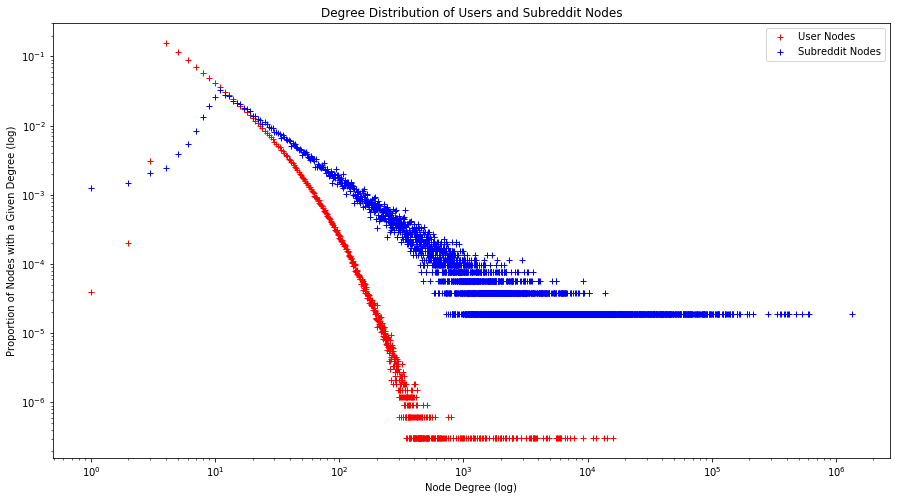

In [33]:
x_user, y_user = getFilteredDataPointsToPlot(C, filtered_nodes=train_users, nodes_dict=user_node_ids)
plt.loglog(x_user, y_user, 'r+', color = 'r', label = 'User Nodes')

x_subreddit, y_subreddit = getFilteredDataPointsToPlot(C, filtered_nodes=train_subreddit_ids, nodes_dict=subreddit_node_ids)
plt.loglog(x_subreddit, y_subreddit, 'b+', color = 'b', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Users and Subreddit Nodes')
plt.legend()
plt.show()

## Construct Subreddit-Subreddit Graph (Shared Users)

In [18]:
def construct_subreddit_graph(users, subreddit_ids, user_node_ids, subreddit_node_ids, user_subreddit_dict):
    # S = snap.PUNGraph.New()
    subreddit_graph_edges = set()
    subreddit_graph_weights = defaultdict(int) # node_id -> weight
    
    # Add subreddit node ids
    # for subreddit_id in subreddit_ids:
    #     S.AddNode(subreddit_node_ids[subreddit_id])

    # Add edges between subreddits
    for i, user in enumerate(users):
        # Get users for subreddit
        projected_subreddits = user_subreddit_dict[user]
        
        # At least two subreddit share this user
        if len(projected_subreddits) >= 2:
            subreddit_pairs = list(itertools.combinations(projected_subreddits, 2))
            for first_subreddit, second_subreddit in subreddit_pairs:
                subreddit_node_ids_ordered = sorted([subreddit_node_ids[first_subreddit], subreddit_node_ids[second_subreddit]])
                first_subreddit_id, second_subreddit_id = subreddit_node_ids_ordered[0], subreddit_node_ids_ordered[1]
                
                subreddit_graph_weights[(first_subreddit_id, second_subreddit_id)] += 1
                subreddit_graph_edges.add((first_subreddit_id, second_subreddit_id))
                
                # S.AddEdge(first_subreddit_id, second_subreddit_id)

        if i % 10000 == 0:
            print "Processed %s / %s users" % (i , len(users))

    return subreddit_graph_edges, subreddit_graph_weights

In [ ]:
S_train_edges, S_train_weights = construct_subreddit_graph(train_users, train_subreddit_ids, user_node_ids, subreddit_node_ids, train_user_subreddit_dict)

In [ ]:
S_test_edges, S_test_weights = construct_subreddit_graph(test_users, test_subreddit_ids, user_node_ids, subreddit_node_ids, test_user_subreddit_dict)

In [ ]:
S_train_cluster_coeff = snap.GetClustCf(S_train, 100)
S_test_cluster_coeff = snap.GetClustCf(S_test, 100)

print "S_train: Clustering Coefficient: ", S_train_cluster_coeff
print "S_test: Clustering Coefficient: ", S_test_cluster_coeff

In [ ]:
print "S_train: Number of nodes: ", S_train.GetNodes()
print "S_train: Number of edges: ", S_train.GetEdges()

print "S_test: Number of nodes: ", S_test.GetNodes()
print "S_test: Number of edges: ", S_test.GetEdges()

In [ ]:
snap.SaveEdgeList(S_train, train_subreddit_graph_file) # save graph to text file

In [ ]:
snap.SaveEdgeList(S_test, test_subreddit_graph_file) # save graph to text file

In [ ]:
train_subreddit_graph_weights_file = 'data/train_subreddit_graph_weights.txt'
test_subreddit_graph_weights_file = 'data/test_subreddit_graph_weights.txt'

np.save(train_subreddit_graph_weights_file, S_train_weights) 
np.save(test_subreddit_graph_weights_file, S_test_weights) 

In [ ]:
x, y = getFilteredDataPointsToPlot(S_train, filtered_nodes=train_subreddit_ids, nodes_dict=subreddit_node_ids)
plt.loglog(x, y, 'r+', color = 'r', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Folded Subreddit Nodes')
plt.legend()
plt.show()

In [ ]:
x, y = getFilteredDataPointsToPlot(S_test, filtered_nodes=test_subreddit_ids, nodes_dict=subreddit_node_ids)
plt.loglog(x, y, 'r+', color = 'r', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Folded Subreddit Nodes')
plt.legend()
plt.show()

In [71]:
train_CmtyV = snap.TCnComV()
train_modularity = snap.CommunityCNM(S_train, train_CmtyV)

print "The modularity of the network is %f" % train_modularity
print "The number of communities found is %f" % len(train_CmtyV)

The modularity of the network is 0.104592
The number of communities found is 39.000000


In [ ]:
test_CmtyV = snap.TCnComV()
test_modularity = snap.CommunityCNM(S_test, test_CmtyV)

print "The modularity of the network is %f" % test_modularity
print "The number of communities found is %f" % len(test_CmtyV)

In [74]:
inv_subreddit_node_id = {node_id: node for node, node_id in subreddit_node_ids.iteritems()}

for Cmty in CmtyV:
    subreddit_names = []
    for subreddit_node_id in Cmty:
        subreddit_id = inv_subreddit_node_id[subreddit_node_id] # subreddit_id -> subreddit_node_id
        subreddit_name = subreddit_name_dict[subreddit_id] # subreddit_id -> subreddit_name
        subreddit_names.append(subreddit_name)
    print "Subreddit Community: "
    print subreddit_names

Subreddit Community: 
['DCEU', 'Straps', 'Udacity', 'LINEwebtoon', 'eMusicofficial', 'FistfulOfFrags', 'Venus_Underground', 'deadofwinter', 'phinvest', 'Pxlsspace', 'lavalrocket', 'Jilledtothis', 'GaybrosGoneWild', 'Nordmenn', 'EmiraKowalska', 'saneorpsycho', 'Reykjavik', 'BmxStreets', 'JokesNumberReference', 'FanOfOctokuro', 'penis_envy', 'acom', 'DissertationSupport', 'HowThough', 'roaches', 'Funnypics', 'BisexualTeens', 'ExperimentalRock', 'RebrandingArvada', 'YoungMonroe', 'DetailSwap', 'food', 'pcproreaders', 'BdsmDIY', 'Pantyhosedgirls', 'slashdot', 'rapmusic', 'howweretheyfilming', 'PkmnTCGCardConcepts', 'IamNumberFour', 'EliteAntal', 'colonysurvival', 'CloudPorn', 'freebord', 'Dearborn', 'GirlsOfLiveme', 'the', 'TamazinCrossman', 'HQ_Trivia', 'Granada', 'carAVclassifieds', 'NewJerseyFreakshow', '3D1X1', 'dllinks', 'EconPapers', 'KaraDelToro', 'Whitestripes', 'hotpast', 'Stretching', 'MHOCMP', 'project64', 'NimbatusGame', '2Bx9S', 'worldstar', 'apchemistry', 'LGBTForeverAlone', 

## Construct User-User Graph (Shared Subreddits)

In [ ]:
def construct_user_graph(users, subreddit_ids, user_node_ids, subreddit_node_ids, subreddit_user_dict):
    U = snap.PUNGraph.New()

    # Add user node ids
    for user in users:
        U.AddNode(user_node_ids[user])

    # Add edges between users
    for i, subreddit_id in enumerate(subreddit_ids):
        # Get users for subreddit
        projected_users = subreddit_user_dict[subreddit_id]
        
        # At least two users share this subreddit
        if len(projected_users) >= 2:
            user_pairs = list(itertools.combinations(projected_users, 2))
            for first_user, second_user in user_pairs:
                U.AddEdge(user_node_ids[first_user], user_node_ids[second_user])
    
        if i % 1000 == 0:
            print "Processed %s / %s subreddits" % (i , len(subreddit_ids))

    return U

In [ ]:
U_train = construct_user_graph(train_users, train_subreddit_ids, user_node_ids, subreddit_node_ids, train_subreddit_user_dict)

In [ ]:
print "U_train: Number of nodes: ", U_train.GetNodes()
print "U_train: Number of edges: ", U_train.GetEdges()

In [ ]:
U_train_cluster_coeff = snap.GetClustCf(U_train, 100)
print "U_train: Clustering Coefficient: ", U_train_cluster_coeff